I received this challenge from a sharing session by Vebits AI

In [4]:
# import the library
import cv2
import numpy as np
import imutils 
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

# Ex 1: line and circles

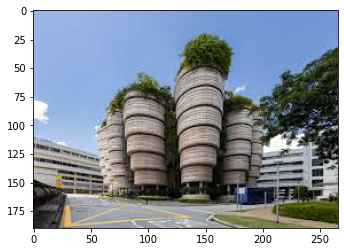

In [5]:
image = cv2.imread('hive.jpg',-1)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

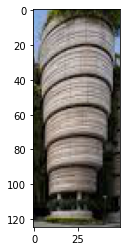

In [6]:
roi = image[45:170,120:170]
plt.imshow(roi)

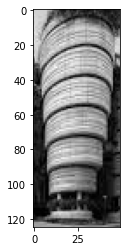

In [7]:
gray=cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
plt.gray()
plt.imshow(gray)

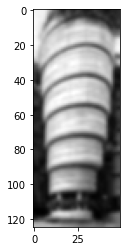

In [8]:
blurred = cv2.GaussianBlur(gray, (11, 11), 1)
plt.imshow(blurred)

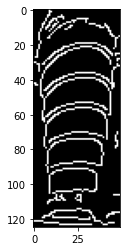

In [88]:
edged = cv2.Canny(blurred, 100, 150)
plt.imshow(edged)

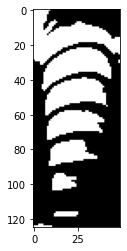

In [97]:


thresh = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh)

6 floors


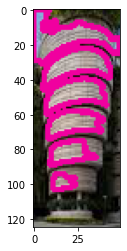

In [98]:
## find contours (i.e., outlines) of the foreground objects in the
# thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
output = roi.copy()
# loop over the contours
cnts = [c for c in cnts if cv2.contourArea(c)> 40]
print(str(len(cnts))+" floors")
for c in cnts:
    # draw each contour on the output image with a 3px thick purple
    # outline, then display the output contours one at a time
    cv2.drawContours(output, [c], -1, (240, 0, 159), 2)
    plt.imshow(output)


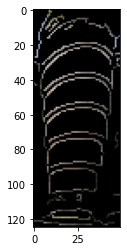

In [14]:
mask = thresh.copy()
output = cv2.bitwise_and(roi, roi, mask=mask)
plt.imshow(output)

642


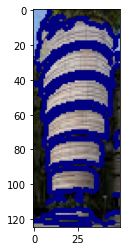

In [99]:
rho_resolution = 1
theta_resolution = np.pi/180
threshold = 0
lines = cv2.HoughLinesP(edged, rho_resolution,theta_resolution, threshold,)

img = roi.copy()
print(len(lines))
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 128), 2)
# Show result
plt.imshow(img)

## QUESTIONS 

1. In this case, using the threshold function to seperate the object and background is sufficient to get the contour?

As you know the OpenCv contour finder is standard. However, prior processings on the image are very important and can make significant changes on the contours. As for the `findContours` function, I would suggest that you try out its different options to have better understanding of the different methods used to extract image contours.

The pre-processing steps depends on the image. For this particular example you have implemented good steps. We usually convert image to grayscale when colors are not of high importance. `Gaussian blur` and extrating edges using `Canny Edges` are also useful which you have done, but sometimes they don't help. You should always plug and unplug them to see what gives better result. In this example you can observe that you haven't used your `edged` image for contours and yet you have produced good contours.

2. When do i use the edges? For this case, it does not help?

Edges can be helpful when thresholded image cannot be produced with good results. But edges are also very useful when you want to detect lines, cirlces, and such.

3. The background blue actually affect my thresholding, What i thought of was changing/removing the blue background before i proceed, But im not sure how to do.

You can mask out the blue sky by masking out its color. You can use the `inRange` function. It's important that you provide good low and high thresholds for this function. Since the image's color are always not perfect (for examply the sky is not a perfect blue), you should either write a code to extract the min/max values within a region or by simply displaying the image window using `imshow` and hover your mouse over the region to observe the min/max color values. Playing the `hue`, `saturation`, and `illumination` (`HSI`) are also helpful besides `RGB`. In most cases `HSI` is more accurate than `RGB`. `HSV` can also be considered for some images. Besides the blue sky I would also mask out the trees.

4. I remember our lab uses HSV to get certain colour. So what if I tune to get a blue mask and mask it with the original photo to remove the background, does it work that way?
Haha I answered this question above. Yes, you should use this methos to mask out the sky.

5. For Hough line, I really dont knwo how to tune it . I tried playing with all the parameters, it doesnt work.
`Hough` has its own limitations. In other words, it expects a good (nearly perfect) image as its input. So, pre-processing for `Hough` is more important than its own parameters. But, what do you mean that it doesn't work?

 any improvement that i can make? or alternative way
 
 I think you already mentioned yourself to improve the result by removing the sky. I would recommend to remove the trees as well. Other than this, everything else that you have done is pretty good.
 
 ### Some Genereal Feedbacks
 - Good job in craeting ROI. This makes image processing very efficient specially when the entire image is not required to be processed.
 - Try playing around with thresholding using colors (RGB, HSI, HSV). You will find that HSI is quite strong. But it's important to play with them and observe the resulting images. It will make a lot of sense to you when you start playing with parameters and visualizing the effects.

# Ex 2: line and circles


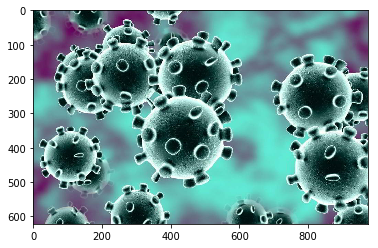

In [306]:
# count number of coron 
corona = cv2.imread('corona.jpg',-1)
corona=cv2.cvtColor(corona, cv2.COLOR_BGR2RGB)
plt.imshow(corona[:,:])
plt.show(block=False)

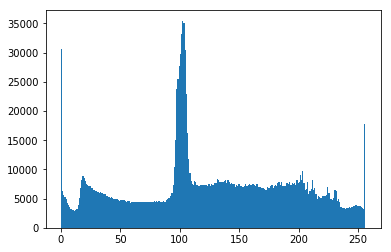

In [413]:
plt.hist(corona.ravel(),256,[0,256]); plt.show()


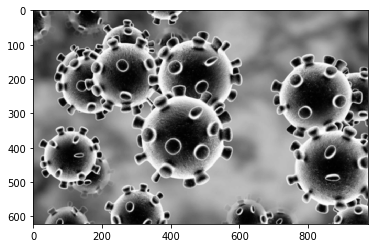

In [418]:
gray=cv2.cvtColor(corona, cv2.COLOR_RGB2GRAY)

blurred = cv2.GaussianBlur(gray, (5, 5), 1.5)
plt.imshow(blurred)


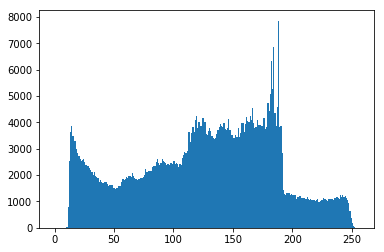

In [419]:
plt.hist(blurred.ravel(),256,[0,256]); plt.show()


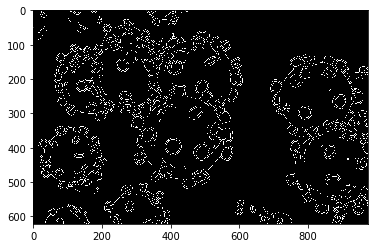

In [412]:
value=160
edged = cv2.Canny(blurred, value/2, value)
plt.imshow(edged)

9 Circles


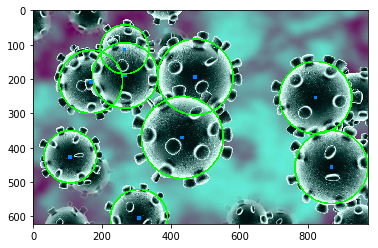

In [608]:
output=corona.copy()
circles=cv2.HoughCircles(blurred,  cv2.HOUGH_GRADIENT, 1,70,param1=160,param2=25,minRadius=70,maxRadius=120)
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	print(str(circles.shape[0])+ " Circles")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
plt.imshow(output)

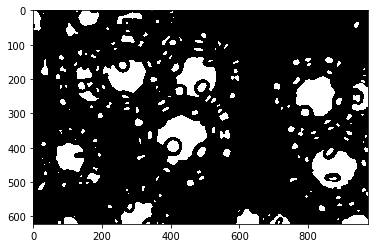

In [604]:

blurred2 = cv2.GaussianBlur(gray, (11,11), 4)
thresh2 = cv2.threshold(blurred2, 60, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(thresh2)

12 Circles


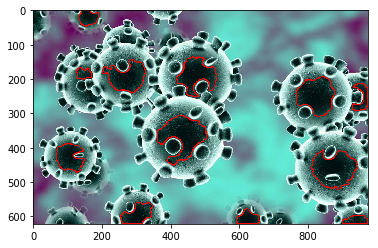

In [609]:
cnts = cv2.findContours(thresh2.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
output=corona.copy()
# loop over the contours
cnts = [c for c in cnts if cv2.contourArea(c)> 1000 and cv2.contourArea(c)<14000.0]

print(str(len(cnts))+ " Circles")
for c in cnts:
    # draw each contour on the output image with a 3px thick purple
    # outline, then display the output contours one at a time
    cv2.drawContours(output, [c], -1, (255, 0, 0), 2)
    plt.imshow(output)

## Questions

1. Actually right, when I perform image smothing to reduce the noise, What kind of graph of image should I get? like how do i know the reduction of noise if enough?
Generally speaking you should not see too many outliers. In other words, it should look like an even distribution. But it's not always the case! You can never know when it is actually enough other than checking the resultant image and further play with parameters if needed.

2. The hough transform is easily affected by the noise, so I need to apply good enough gaussian blur to make it work. this algorithm require a lot of tuning. I dont feel like it's very feasible in real life when there's a lot of noise.
You are exactly right and that's why deep learning performs better than conventional image processing. As you gain experience you would know which noise deduction techniques to use. So, it's quite normal for you to be frustrated with what works well and how well. Besides `Gaussian Blur`, I'd suggest that you try out `dilate` and `erode` as well. I also suggest you search and read about image segmentation with OpenCV.

3. I tried using thresholding method to do, it's also not that good, it cant get a nice circle as I failed to get a cleaned threshold.
What do you mean thresholding method? There different types of thresholdings. But, since you started your computer vision journey with deep learning you'll get frustrated with image processing techniques. Be patient and play with more challenging examples. In time, you will know what methods to use when seeing an image. However, in many cases, we will have to use try and error methods. As you get experienced with different images, you can do it much faster.

Are there any other method ? How can i improve?

I think I mentioned some suggestions above. By the way, OpenCV 4 has been released. I haven't had the time to check the improvements. Check it out when you can.

# Ex 3: face detection ignore first


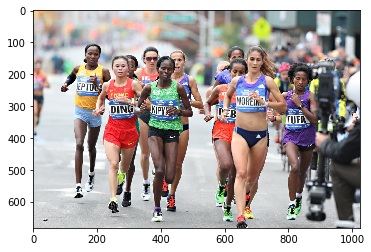

In [13]:
import dlib 
# improve face detection 
face = cv2.imread('marathon.jpg')
plt.imshow(face[:,:,::-1])
plt.show(block=False)

Number of faces detected: 7
Detection 0: Left: 252 Top: 161 Right: 295 Bottom: 204
Detection 1: Left: 818 Top: 204 Right: 861 Bottom: 247
Detection 2: Left: 671 Top: 141 Right: 723 Bottom: 193
Detection 3: Left: 165 Top: 127 Right: 208 Bottom: 170
Detection 4: Left: 429 Top: 146 Right: 472 Bottom: 190
Detection 5: Left: 395 Top: 170 Right: 439 Bottom: 214
Detection 6: Left: 352 Top: 142 Right: 395 Bottom: 185


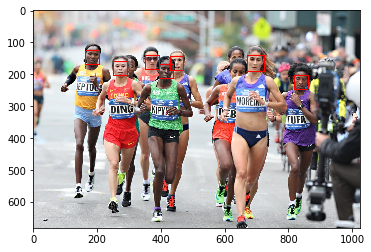

In [14]:
color = (0, 0, 255) 
thickness = 2

detector = dlib.get_frontal_face_detector()
dets = detector(face, 1)
print("Number of faces detected: {}".format(len(dets)))
for i, d in enumerate(dets):
    print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        i, d.left(), d.top(), d.right(), d.bottom()))
    face = cv2.rectangle(face, (d.left(), d.top()), (d.right(), d.bottom()), color, thickness) 

plt.imshow(face[:,:,::-1])
plt.show(block=False)  




In [19]:
!wget https://www.incimages.com/uploaded_files/image/970x450/getty_938993594_401542.jpg

--2020-02-07 09:24:24--  https://www.incimages.com/uploaded_files/image/970x450/getty_938993594_401542.jpg
Resolving www.incimages.com (www.incimages.com)... 151.101.10.59
Connecting to www.incimages.com (www.incimages.com)|151.101.10.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105420 (103K) [image/jpeg]
Saving to: ‘getty_938993594_401542.jpg’

getty_938993594_401 100%[===================>] 102.95K  --.-KB/s    in 0.008s  

2020-02-07 09:24:29 (13.0 MB/s) - ‘getty_938993594_401542.jpg’ saved [105420/105420]

